Import packages to be used and define local path to acess files downloded from https://www.kaggle.com/competitions/titanic

In [7]:
import os
import pandas as pd
import matplotlib as plt
import numpy as np

import pickle

from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, ConfusionMatrixDisplay, RocCurveDisplay, PrecisionRecallDisplay


from xgboost import XGBClassifier
from xgboost import plot_importance

os.chdir('/Users/paulorusso/Downloads/titanic')
os.getcwd()

'/Users/paulorusso/Downloads/titanic'

Naming datasets as df_train and df_test based on files downloded for the Kaggle competition.

In [8]:
df_train = pd.read_csv('train.csv')
df_test = pd.read_csv('test.csv')

Some features are not necessary for the model so removing from both data sets the columns:

- 'Name'
- 'Ticket'
- 'Cabin' 
- 'PassengerId' 

Not dropping missing values for this study.

In [9]:
df_train1 = df_train.drop(['Name', 'Ticket', 'Cabin', 'PassengerId'] ,axis=1)
df_test1 = df_test.drop(['Name', 'Ticket', 'Cabin', 'PassengerId'] ,axis=1)

In [10]:
df_train1.head()

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked
0,0,3,male,22.0,1,0,7.2500,S
1,1,1,female,38.0,1,0,71.2833,C
2,1,3,female,26.0,0,0,7.9250,S
3,1,1,female,35.0,1,0,53.1000,S
4,0,3,male,35.0,0,0,8.0500,S


In [11]:
df_test1.head()

,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked
0,3,male,34.5,0,0,7.8292,Q
1,3,female,47.0,1,0,7.0000,S
2,2,male,62.0,0,0,9.6875,Q
3,3,male,27.0,0,0,8.6625,S
4,3,female,22.0,1,1,12.2875,S


Time to convert the categorical features into numerical.

In [12]:
df_train2 = pd.get_dummies(df_train1, dtype=int)
df_test2 = pd.get_dummies(df_test1, dtype=int)

In [13]:
df_train2.head()

,Survived,Pclass,Age,SibSp,Parch,Fare,Sex_female,Sex_male,Embarked_C,Embarked_Q,Embarked_S
0,0,3,22.0,1,0,7.2500,0,1,0,0,1
1,1,1,38.0,1,0,71.2833,1,0,1,0,0
2,1,3,26.0,0,0,7.9250,1,0,0,0,1
3,1,1,35.0,1,0,53.1000,1,0,0,0,1
4,0,3,35.0,0,0,8.0500,0,1,0,0,1


In [14]:
df_test2.head()


,Pclass,Age,SibSp,Parch,Fare,Sex_female,Sex_male,Embarked_C,Embarked_Q,Embarked_S
0,3,34.5,0,0,7.8292,0,1,0,1,0
1,3,47.0,1,0,7.0000,1,0,0,0,1
2,2,62.0,0,0,9.6875,0,1,0,1,0
3,3,27.0,0,0,8.6625,0,1,0,0,1
4,3,22.0,1,1,12.2875,1,0,0,0,1


Before we isolate, is good to check the class imbalance of target variable, which is about 60% to 40%, seems good.

In [15]:
df_train2['Survived'].value_counts(normalize=True)

Survived
0    0.616162
1    0.383838
Name: proportion, dtype: float64

Isolate the target (column Survived), divide the 'df_train2' dataset for modelling and instantiate the XGB model.

In [95]:
y = df_train2['Survived']

X = df_train2.drop('Survived',axis=1)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.25, random_state = 0)

xgb = XGBClassifier(objective='binary:logistic', random_state=0)

Define the hyperparameters and scoring.

In [70]:
cv_params = {'max_depth': [6, 10],
              'min_child_weight': [5, 8],
              'learning_rate': [0.1, 0.2, 0.3],
              'n_estimators': [10,15,25],
              'subsample': [0.7],
              'colsample_bytree': [0.7]
              }

scoring = ['accuracy', 'precision', 'recall', 'f1']

Construct Gridsearch for cross validation

In [90]:
xgb_cv = GridSearchCV(xgb,
                      cv_params,
                      scoring = scoring,
                      cv = 5,
                      refit = 'accuracy'
                     )

Train the model

In [96]:
%%time
xgb_cv = xgb_cv.fit(X_train, y_train)
xgb_cv

CPU times: user 8.98 s, sys: 2.98 s, total: 12 s
Wall time: 1.62 s


GridSearchCV(cv=5,
             estimator=XGBClassifier(base_score=None, booster=None,
                                     callbacks=None, colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None, device=None,
                                     early_stopping_rounds=None,
                                     enable_categorical=False, eval_metric=None,
                                     feature_types=None, gamma=None,
                                     grow_policy=None, importance_type=None,
                                     interaction_constraints=None,
                                     learning_rate=None,...
                                     missing=nan, monotone_constraints=None,
                                     multi_strategy=None, n_estimators=None,
                                     n_jobs=None, num_parallel_tree=None,
                                     random_state=0, ...),
             param_grid={'colsample_bytree': [0.7],
                         'learning_rate': [0.1, 0.2, 0.3], 'max_depth': [6, 10],
                         'min_child_weight': [5, 8],
                         'n_estimators': [10, 15, 25], 'subsample': [0.7]},
             refit='accuracy',
             scoring=['accuracy', 'precision', 'recall', 'f1'])

Check best paraments

In [97]:
xgb_cv.best_params_

{'colsample_bytree': 0.7,
 'learning_rate': 0.3,
 'max_depth': 10,
 'min_child_weight': 5,
 'n_estimators': 25,
 'subsample': 0.7}

Create a function to output results in a table, so in case a new model is used, we can use the table tro compare them

In [74]:
def make_results(model_name:str, model_object, metric:str):
    '''
    Arguments:
        model_name (string): what you want the model to be called in the output table
        model_object: a fit GridSearchCV object
        metric (string): precision, recall, f1, or accuracy

    Returns a pandas df with the F1, recall, precision, and accuracy scores
    for the model with the best mean 'metric' score across all validation folds.
    '''

    # Create dictionary that maps input metric to actual metric name in GridSearchCV
    metric_dict = {'precision': 'mean_test_precision',
                   'recall': 'mean_test_recall',
                   'f1': 'mean_test_f1',
                   'accuracy': 'mean_test_accuracy',
                   }

    # Get all the results from the CV and put them in a df
    cv_results = pd.DataFrame(model_object.cv_results_)

    # Isolate the row of the df with the max(metric) score
    best_estimator_results = cv_results.iloc[cv_results[metric_dict[metric]].idxmax(), :]

    # Extract accuracy, precision, recall, and f1 score from that row
    f1 = best_estimator_results.mean_test_f1
    recall = best_estimator_results.mean_test_recall
    precision = best_estimator_results.mean_test_precision
    accuracy = best_estimator_results.mean_test_accuracy

    # Create table of results
    table = pd.DataFrame({'model': [model_name],
                          'precision': [precision],
                          'recall': [recall],
                          'F1': [f1],
                          'accuracy': [accuracy],
                          },
                         )

    return table

Output model results in a table

In [98]:
results = make_results('XGB cv', xgb_cv, 'accuracy')
results

,model,precision,recall,F1,accuracy
0,XGB cv,0.827899,0.70543,0.759103,0.827887


Create another function to output the results made on test (untouched) data

In [63]:
def get_test_scores(model_name:str, preds, y_test_data):
    '''
    Generate a table of test scores.

    In:
        model_name (string): Your choice: how the model will be named in the output table
        preds: numpy array of test predictions
        y_test_data: numpy array of y_test data

    Out:
        table: a pandas df of precision, recall, f1, and accuracy scores for your model
    '''
    accuracy = accuracy_score(y_test_data, preds)
    precision = precision_score(y_test_data, preds)
    recall = recall_score(y_test_data, preds)
    f1 = f1_score(y_test_data, preds)

    table = pd.DataFrame({'model': [model_name],
                          'precision': [precision],
                          'recall': [recall],
                          'F1': [f1],
                          'accuracy': [accuracy]
                          })

    return table

Use XGBoost model to predict on test data, get test scores for XGBoost model and append to the results to the same table

In [99]:
xgb_test_preds = xgb_cv.best_estimator_.predict(X_test)

xgb_test_scores = get_test_scores('XGB test', xgb_test_preds, y_test)

results = pd.concat([results, xgb_test_scores], axis=0)
results

,model,precision,recall,F1,accuracy
0,XGB cv,0.827899,0.70543,0.759103,0.827887
0,XGB test,0.847222,0.72619,0.782051,0.847534


Use XGBoost model to make predictions from the external dataset (untouched) from Kaggle

In [100]:
xgb_test_EXT_preds = xgb_cv.best_estimator_.predict(df_test2)

Create a dataset in the format requested by Kaggle

In [101]:
pax_id = df_test['PassengerId']

d = {'PassengerId': pax_id, 'Survived': (xgb_test_EXT_preds)}

gender_submission = pd.DataFrame(data=d)

gender_submission.head()

,PassengerId,Survived
0,892,0
1,893,0
2,894,0
3,895,0
4,896,1


Save output table as csv

In [79]:
gender_submission.to_csv('my_gender_submission.csv', index=False)  

Generate array of values for confusion matrix and plot

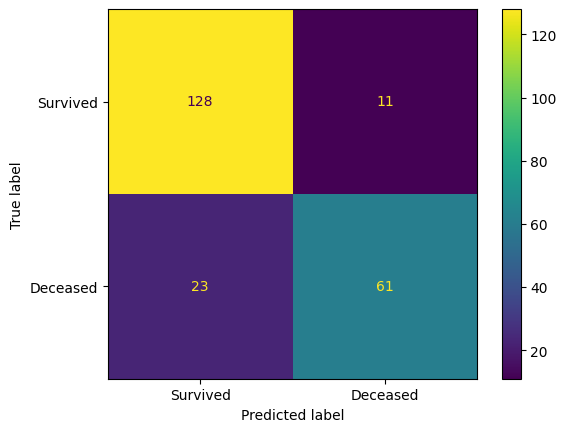

In [102]:
cm = confusion_matrix(y_test, xgb_test_preds, labels=xgb_cv.classes_)

disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                             display_labels=['Survived', 'Deceased'])
disp.plot()

Plot feature importance to check what features had more weight in the prediction.

<Axes: title={'center': 'Feature importance'}, xlabel='F score', ylabel='Features'>

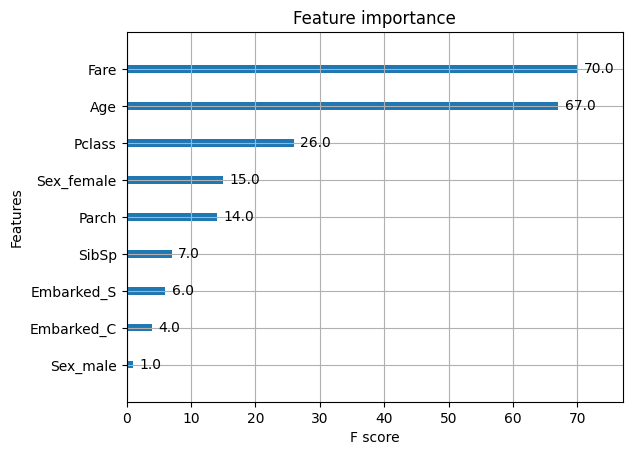

In [103]:
plot_importance(xgb_cv.best_estimator_)

Conclusions:

- XGBoost model had an accuracy of approx 83% on predicting passengers who survived on Titanic or not;
- The variables that contributed more to the predictions were the Fare, followed by Age and Pclass (Passenger Class);